# Part 1: Please answer the following questions



1. What are the advantages and disadvantages of Normalizing Flow Models? List them and explain.
2. What is the *change of variables*? Explain.
3. What are the key properties of transformations? Explain.
4. Compare ***Masked Autoregressive Flows (MAF)*** with ***Inverse Autoregressive Flows (IAF)*** and discuss their advantages and disadvantages.

---
 ***YOUR ANSWER HERE***

  1. **Advantages**

    - Optimize the exact log-likelihood of the data, $\log (p_X)$, it is not the case with VAEs and GANs.

    - Infer exact latent-variable values $z$, which are useful for downstream tasks
    - Potential for memory savings, with NFs gradient computations scaling constant to their depth
    - Requires only an encoder to be learned
    - Tractable likelihood evaluation
    - Invertible transformations with tractable evaluation

    **Disadvantages**

    - It doesn't scale well with high dimensional latent spaces
    - Computing $n \times n$ Jacobian matrices
    - The requirements of invertibility and efficient Jacobian calculations restrict model architecture
    - Generative results are still behind VAEs and GANs

  2. Change of variables is a technique to simplify the complex problems in which the original variables are replaced with functions of other variables. Mathematically, the change of variables is the mapping between $Z$ and $X$ given by $\mathbf{f}:\mathbb{R}^n \mapsto \mathbb{R}^n$ is invertible such that $X = f(Z)$ and $Z = f^{-1}(X)$.
  $$p_{X}(\mathbf{x})=p_{Z}\left(\mathbf{f}^{-1}(\mathbf{x})\right)\left|\operatorname{det}\left(\frac{\partial \mathbf{f}^{-1}(\mathbf{x})}{\partial \mathbf{x}}\right)\right|$$

  3. Properties;
    - Should be invertible (and differentiable)
    - $x$ and $z$ should be continuous and have the same dimension
    - Computation of Jacobian should be efficient
    - Determinant of the Jacobian should not be indefinite

  4. 

| MAF | IAF |
|:--------:|:---------:|
|$x_i$ depends on $x_{1:i-1}$ and $z_i$. | $x_i$ depends on $z_{1:i-1}$ and $z_i$. |
|Likelihoods can be evaluated in parallel| Likelihoods are evaluated sequentially|
|Fast training | Slow training|
|$x$ is sampled sequentially | $x$ can be sampled in parallel|
|Slow sampling|Fast sampling|
|Suitable for training based on MLE|Suitable for real-time generation|


 
$.$ 

---

# Part 2: Pen & Paper Example

Let Z be a uniform random vector in $[0,1]^2$ and let $A = \left[\begin{array}{ll}
3 & 5 \\
1 & 3
\end{array}\right]$. Letting $X = AZ$, calculate $p_X(4,2)$ using both forward and inverse transformation.

---
 ***YOUR ANSWER HERE***

 Let $Z = A^{-1}X = WX$. By taking the inverse of $A$ we can find $W$ as;
 
 $W = \left[\begin{array}{rr}
0.75 & -1.25 \\
-0.25 & 0.75
\end{array}\right]$.

So, the point $(4,2)$ on the **x**-domain is transformed from $(0.5,0.5)$ on the **z**-domain.

Now, let's remember the change of variable formula in general;

 - **Inverse**: $ p_{X}(\mathbf{x})=p_{Z}\left(\mathbf{f}^{-1}(\mathbf{x})\right)\left|\operatorname{det}\left(\frac{\partial \mathbf{f}^{-1}(\mathbf{x})}{\partial \mathbf{x}}\right)\right| $
 - **Forward**: $p_{X}(\mathbf{x})=p_{Z}(\mathbf{z})\left|\operatorname{det}\left(\frac{\partial \mathbf{f}(\mathbf{z})}{\partial \mathbf{z}}\right)\right|^{-1}$

where $f(z) = AZ$, and $f^{-1}(x) = WX$. So, we can further simplify the inverse and forward formulations as;

 - **Inverse**: $ p_{X}(\mathbf{x})=p_{Z}\left(Wx\right)\left|\operatorname{det}\left(W\right)\right| $
 - **Forward**: $p_{X}(\mathbf{x})=p_{Z}(\mathbf{z})\left|\operatorname{det}\left(A\right)\right|^{-1}$

If we calculate the determinants of $A$ and $W$, we can get the following;
\begin{align}
det(A) &= 4 \\
det(W) &= 0.25
\end{align}

So, by using **inverse** calculations;
\begin{align}
p_x\left( \left[\begin{array}{r}
4 \\
2
\end{array}\right] \right) &= p_z\left(\left[\begin{array}{rr}
0.75 & -1.25 \\
-0.25 & 0.75
\end{array}\right] \left[\begin{array}{r}
4 \\
2
\end{array}\right]\right) \times det(W) \\
&= p_z\left(\left[\begin{array}{r}
0.5 \\
0.5
\end{array}\right]\right) \times 0.25 \\
&= 1 \times 0.25 = 0.25
\end{align}


By using **forward** calculations;
\begin{align}
p_x\left( \left[\begin{array}{r}
4 \\
2
\end{array}\right] \right) &= p_z\left(\left[\begin{array}{r}
0.5 \\
0.5
\end{array}\right]\right) \times det(A)^{-1} \\
&= 1 \times 4^{-1} \\
&= 0.25
\end{align}



 ---

# Part 3: Implementation of Normalizing Flows

Normalizing flow implementation task is modified from [Artificial Creative Intelligence and Data Science](https://github.com/acids-ircam/pytorch_flows)'s tutorial.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define grids of points (for later plots)
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

## Transforming distributions

### Change of variables and flow

In order to transform a probability distribution, we can perform a *change of variable*. In general, change of variables can be performed in any number of ways. However, here we are interested in probability distributions, which means that we need to *scale* our transformed density so that the total probability still sums to one. This is directly measured with the determinant of our transform (please check [Eric Jang's tutorial](https://blog.evjang.com/2018/01/nf1.html) for examples). Hence, we can transform a probability distribution by using an invertible mapping and somehow scaling by the determinant of this mapping. 

Let $\mathbf{z}\in\mathcal{R}^d$ be a random variable with distribution $q(\mathbf{z})$ and $f:\mathcal{R}^d\rightarrow\mathcal{R}^d$ an invertible smooth mapping (meaning that $f^{-1} = g$ and $g\circ f(\mathbf{z})=\mathbf{z}'$. We can use $f$ to transform $\mathbf{z}\sim q(\mathbf{z})$. The resulting random variable $\mathbf{z}'=f(\mathbf{z})$ has the following probability distribution

$$
q(\mathbf{z}')=q(\mathbf{z})\left|\text{ det}\frac{\delta f^{-1}}{\delta \mathbf{z}'}\right| = q(\mathbf{z})\left|\text{ det}\frac{\delta f}{\delta \mathbf{z}}\right|^{-1}
\tag{1}
$$

where the last equality is obtained through the inverse function theorem [1]. 

This can be easily implemented in PyTorch with the `Transform` classes, that already defines some basic probability distribution transforms. In this notebook, we will mainly use `Transform` classes. However, we start with following example: if we define $\mathbf{z}\sim q_0(\mathbf{z})=\mathcal{N}(0, 1)$, we can apply the transform $\mathbf{z}'=exp(\mathbf{z})$ so that $\mathbf{z}'\sim q_1(\mathbf{z}')$. You can check your own implementation with torch implementation.

In [3]:
class ExponentialTransfrom(transform.Transform):
    r"""
    Transform via the mapping :math:`y = \exp(x)`.
    """
    def __init__(self):
        super(ExponentialTransfrom, self).__init__()
        self.domain = torch.distributions.constraints.real
        self.codomain = torch.distributions.constraints.positive
        self.bijective = True

    def _call(self, x):
        return self._forward(x)

    def _forward(self, x):
        #YOUR CODE HERE
        return x.exp()

    def _inverse(self, y):
        #YOUR CODE HERE
        return y.log()

    def log_abs_det_jacobian(self, x, y):
        #YOUR CODE HERE
        return x

In [4]:
q0 = distrib.Normal(0, 1, validate_args=False)
exp_transform = ExponentialTransfrom()
q1 = distrib.TransformedDistribution(q0, exp_transform, validate_args=False)

Let's first observe the distributions of `q0` and `q1` using their samples:

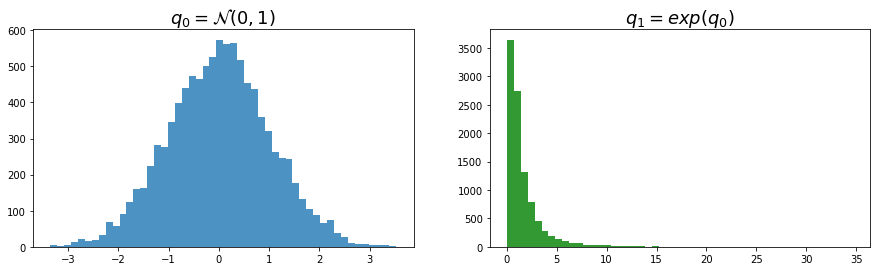

In [5]:
samples_q0 = q0.sample((int(1e4),))
samples_q1 = q1.sample((int(1e4),))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.hist(samples_q0, 50, alpha=0.8);
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18);
ax2.hist(samples_q1, 50, alpha=0.8, color='g');
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);

Since the objects `q0` and `q1` are defined as `Distribution`, we can observe their true densities by using `log_prob` instead of just empirical samples

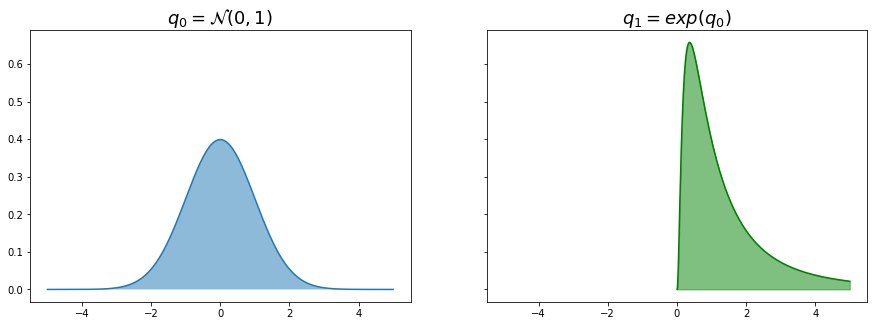

In [6]:
q0_density = torch.exp(q0.log_prob(torch.Tensor(x))).numpy()
q1_density = torch.exp(q1.log_prob(torch.Tensor(x))).numpy()
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 5))
ax1.plot(x, q0_density); ax1.fill_between(x, q0_density, 0, alpha=0.5)
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18);
ax2.plot(x, q1_density, color='g'); ax2.fill_between(x, q1_density, 0, alpha=0.5, color='g')
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);

### Chaining transforms (normalizing flows)

Now, if we start with a random vector $\mathbf{z}_0$ with distribution $q_0$, we can apply a series of mappings $f_i$, $i \in 1,\cdots,k$ with $k\in\mathcal{N}^{+}$ and obtain a normalizing flow. Hence, if we apply $k$ normalizing flows, we obtain a chain of change of variables

$$
\mathbf{z}_k=f_k\circ f_{k-1}\circ...\circ f_1(\mathbf{z}_0)
\tag{2}
$$

Therefore the distribution of $\mathbf{z}_k\sim q_k(\mathbf{z}_k)$ will be given by
   
   $$
   \begin{align}
   q_k(\mathbf{z}_k) &= q_0(f_1^{-1} \circ f_{2}^{-1} \circ ... \circ f_k^{-1}(\mathbf{z}_k))\prod_{i=1}^k\left|\text{det}\frac{\delta f^{-1}_i}{\delta\mathbf{z}_{i}}\right|\\
   &= q_0(\mathbf{z_0})\prod_{i=1}^k\left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|^{-1}
   \end{align}
   \tag{3}
   $$
    
where we compute the determinant of the Jacobian of each normalizing flow (as explained in the previous section). This series of transformations can transform a simple probability distribution (e.g. Gaussian) into a complicated multi-modal one. As usual, we will rely on log-probabilities to simplify the computation and obtain 

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right| 
\tag{4}
$$


To be of practical use, however, we can consider only transformations whose determinants of Jacobians are easy to compute. Of course, we can perform any amount of combined transformations, and it also works with multivariate distributions. Here, this is demonstrated by transforming a `MultivariateNormal` successively with an `ExpTransform` and `AffineTransform`.

In [7]:
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2), validate_args=False)
# Define an exponential transform (using torch implementation)
#YOUR CODE HERE
f1 = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, f1, validate_args=False)
# Define an affine transform with loc=2 and scale=[0.2, 1.5]
#YOUR CODE HERE
f2 = transform.AffineTransform(loc=2, scale=torch.Tensor([0.2, 1.5]))
# Here we define q2 as a transform on q1
#YOUR CODE HERE
q2 = distrib.TransformedDistribution(q1, f2, validate_args=False)
# Here we define q3 as a sequence of transforms on q0
q3 = distrib.TransformedDistribution(q0, [f1, f2], validate_args=False)

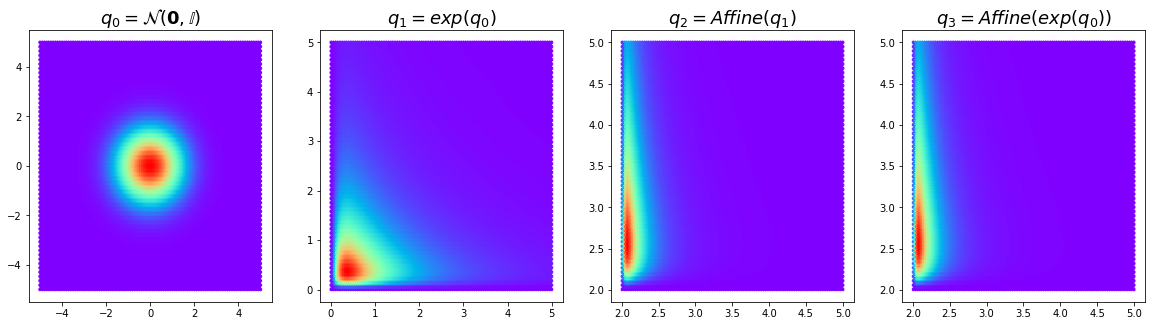

In [8]:
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
q1_density = torch.exp(q1.log_prob(torch.Tensor(z)))
q2_density = torch.exp(q2.log_prob(torch.Tensor(z)))
q3_density = torch.exp(q2.log_prob(torch.Tensor(z)))
# Plot all these lads
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density, cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(z[:,0], z[:,1], C=q1_density, cmap='rainbow')
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);
ax3.hexbin(z[:,0], z[:,1], C=q2_density, cmap='rainbow')
ax3.set_title('$q_2=Affine(q_1)$', fontsize=18);
ax4.hexbin(z[:,0], z[:,1], C=q3_density, cmap='rainbow')
ax4.set_title('$q_3=Affine(exp(q_0))$', fontsize=18);

Note that Figure 3 and Figure 4 should be the same.

## Normalizing flows

Now, we are interested in normalizing flows as we could define our own flows. And, most importantly, we could optimize the parameters of these flow in order to fit complex and richer probability distributions. We will see how this plays out by trying to implement the *planar flow* proposed in the original paper by Rezende [1].

### Planar flow

 A planar normalizing flow is defined as a function of the form

   $$
   f(\mathbf{z})=\mathbf{z}+\mathbf{u}h(\mathbf{w}^T\mathbf{z}+b)
   \tag{5}
   $$

   where $\mathbf{u}\in\mathbb{R}^D$ and $\mathbf{w}\in\mathbb{R}^D$ are vectors (called here scale and weight), $b\in\mathbb{R}$ is a scalar (bias) and $h$ is an activation function. These transform functions are chosen depending on the fact that
1. the determinant of their Jacobian can be computed in linear time
2. the transformation is invertible (under usually mild conditions only)
   
As shown in the paper, for the planar flow, the determinant of the Jacobian can be computed in $O(D)$ time by relying on the matrix determinant lemma

$$
\psi(\mathbf{z})=h'(\mathbf{w}^T\mathbf{z}+b)\mathbf{w}
\tag{6}
$$

$$
\left|\text{det}\frac{\delta f}{\delta\mathbf{z}}\right| = \left|\text{det}\left(\mathbf{I}+\mathbf{u}\psi(\mathbf{z})^{T}\right)\right|=\left|1+\mathbf{u}^T\psi(\mathbf{z})\right|
\tag{7}
$$

Therefore, we have all definitions that we need to implement this flow as a `Transform` object. Note that here the non-linear activation function $h$ is selected as a $tanh$. Therefore the derivative $h'$ is $1-tanh(x)^2$

In [9]:
class PlanarFlow(transform.Transform):

    def __init__(self, weight, scale, bias):
        super(PlanarFlow, self).__init__()
        self.bijective = False
        self.domain = torch.distributions.constraints.Constraint()
        self.codomain = torch.distributions.constraints.Constraint()
        self.weight = weight
        self.scale = scale
        self.bias = bias

    def _call(self, z):
        return self._forward(z)

    def _forward(self, z):
        #YOUR CODE HERE
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        #YOUR CODE HERE
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

In [10]:
w = torch.Tensor([[3., 0]])
u = torch.Tensor([[2, 0]])
b = torch.Tensor([0])
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2), validate_args=False)
flow_0 = PlanarFlow(w, u, b)
q1 = distrib.TransformedDistribution(q0, flow_0, validate_args=False)

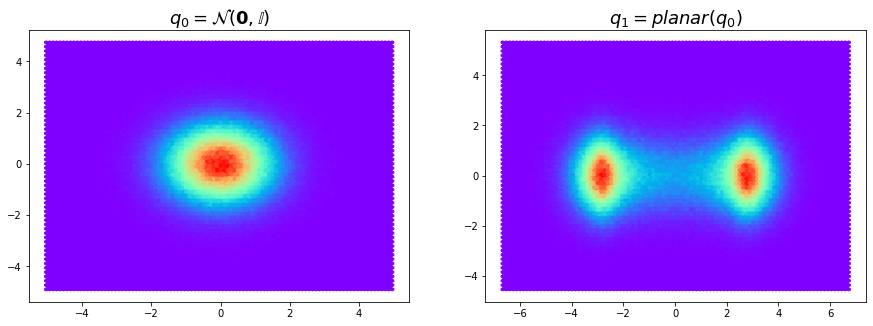

In [11]:
q0_samples = q0.sample((int(1e6), ))
q1_samples = q1.sample((int(1e6), ))
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hexbin(q0_samples[:,0], q0_samples[:,1], cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(q1_samples[:,0], q1_samples[:,1], cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

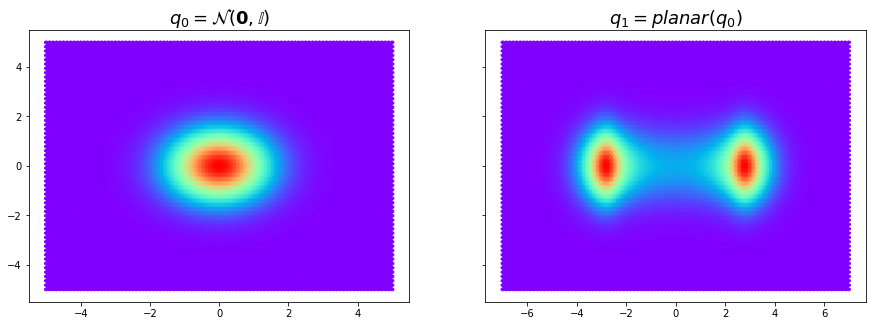

In [12]:
q0_density = torch.exp(q0.log_prob(torch.Tensor(z))).numpy().squeeze()
# Apply our transform on coordinates
f_z = flow_0(torch.Tensor(z))
# Obtain our density
q1_density = q0_density / np.exp(flow_0.log_abs_det_jacobian(torch.Tensor(z)).squeeze())
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density, cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density, cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

## Optimizing normalizing flows

Now that we have this magnificent tool, we would like to apply this in order to learn richer distributions and perform *inference*. Now, we have to deal with the fact that the `Transform` object is not inherently parametric and cannot yet be optimized similarly to other modules.

To do so, we will start by defining our own `Flow` class which can be seen both as a `Transform` and also a `Module`that can be optmized

In [13]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

Thanks to this little trick, we can use the same `PlanarFlow` class as before, 
that we put back here just to show that the only change is that it now inherits from the `Flow` class (with the small added bonus that now parameters of this flow are also registered in the `Module` interface)

In [14]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.domain = torch.distributions.constraints.Constraint()
        self.codomain = torch.distributions.constraints.Constraint()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()

    def _call(self, z):
        return self._forward(z)

    def _forward(self, z):
        #YOUR CODE HERE
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        #YOUR CODE HERE
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

Now, let's generate complex distribution to find;

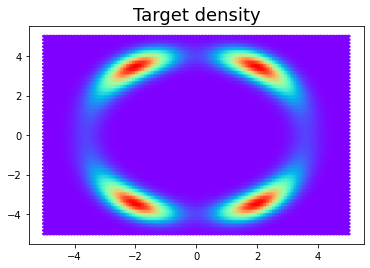

In [15]:
def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# Plot it
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18);

Now create a normalizing flow model with flow_length of 16 and with a reference distribution of 2-dimensional unit MultivariateNormal distribution.

In [16]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            biject.append(PlanarFlow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
    
# Create normalizing flow
# YOUR CODE HERE
flow = NormalizingFlow(dim=2, flow_length=16, density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))

Define the loss function;

$$
\max _{\theta} \log p_{X}(\mathcal{D} ; \theta)=\sum_{\mathbf{x} \in \mathcal{D}} \log p_{Z}\left(\mathbf{f}_{\theta}^{-1}(\mathbf{x})\right)+\log \left|\operatorname{det}\left(\frac{\partial \mathbf{f}_{\theta}^{-1}(\mathbf{x})}{\partial \mathbf{x}}\right)\right|
$$

In [17]:
def loss(density, zk, log_jacobians):
    # YOUR CODE HERE
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk)+1e-9)).mean()

In [18]:
import torch.optim as optim
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=2e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

Loss (it. 0) : 18.383629
Loss (it. 1000) : 1.451391
Loss (it. 2000) : 1.118999
Loss (it. 3000) : 1.173743
Loss (it. 4000) : 1.031349
Loss (it. 5000) : 0.852113
Loss (it. 6000) : 0.927163
Loss (it. 7000) : 0.855323
Loss (it. 8000) : 0.892364
Loss (it. 9000) : 0.852886
Loss (it. 10000) : 0.978909


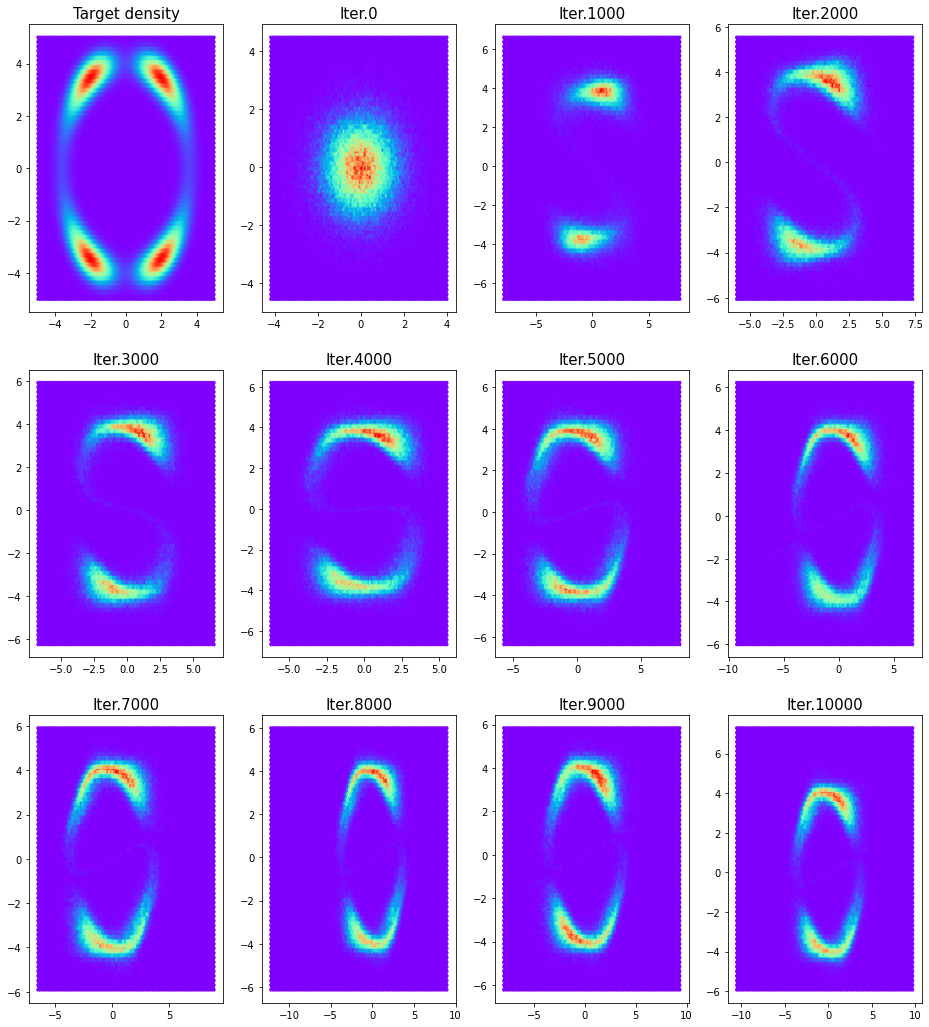

In [19]:
ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
id_figure=2
plt.figure(figsize=(16, 18))
plt.subplot(3,4,1)
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=15);
# Main optimization loop
for it in range(10001):
    # Draw a sample batch from Normal
    samples = ref_distrib.sample((512, ))
    # Evaluate flow of transforms
    zk, log_jacobians = flow(samples)
    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = loss(density_ring, zk, log_jacobians)
    loss_v.backward()
    optimizer.step()
    scheduler.step()
    if (it % 1000 == 0):
        print('Loss (it. %i) : %f'%(it, loss_v.item()))
        # Draw random samples
        samples = ref_distrib.sample((int(1e5), ))
        # Evaluate flow and plot
        zk, _ = flow(samples)
        zk = zk.detach().numpy()
        plt.subplot(3,4,id_figure)
        plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
        plt.title('Iter.%i'%(it), fontsize=15);
        id_figure += 1

---
Note that printed loss should start from ~18 and goes down to ~0.5.